In [2]:
%load_ext rpy2.ipython

In [4]:
%%R
library(dplyr)
library(readr)
library(tidyr)
library(ggplot2)
library(phyloseq)

In [6]:
%%R
otu_tab = read_csv("data/EC_table.noMC.csv") %>% {
    rownames(.) = .$seq_id
    .
    } %>%
    select(-seq_id) %>%
    as.matrix %>%
    otu_table(taxa_are_rows = TRUE)

tax_tab = read_csv("data/tax_table.csv") %>% {
    rownames(.) = .$seq_id
    .
    } %>%
    select(-seq_id) %>%
    as.matrix %>%
    tax_table

sample_tab = read_csv("data/sample_data.csv") %>% {
    rownames(.) = .$sample
    .
    } %>%
    select(-sample) %>%
    data.frame %>%
    sample_data

tree = phy_tree(ape::read.tree("data/variants.tree"))

ps = phyloseq(otu_tab, tax_tab, sample_tab, tree) %>%
    prune_samples((sampleSums(.) > 1000)&
                  (sample_data(.)$star == "star"), .) %>%
    transform_sample_counts(function(x) x / sum(x))
        
ps          

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9292 taxa and 75 samples ]
sample_data() Sample Data:       [ 75 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 9292 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9292 tips and 9288 internal nodes ]


In [7]:
%%R
mdf = psmelt(ps) %>% tbl_df
head(mdf)

# A tibble: 6 × 19
          OTU   Sample Abundance Sample_number X96.Well.Plate.Location
        <chr>    <chr>     <dbl>         <int>                   <chr>
1  Sequence.8  C512_PC 0.9902242            83                 P1 - B8
2 Sequence.36  C446_PC 0.9826398            72                 P1 - B7
3  Sequence.8  C556_PC 0.9809805            86                 P1 - E8
4 Sequence.16 X8567_PC 0.8383326            37                 P1 - G3
5 Sequence.41 X8508_TF 0.8116402             9                 P1 - E1
6 Sequence.24  C326_TF 0.7591402            68                 P1 - F6
# ... with 14 more variables: Sample.Amount <chr>, Genus.Species <chr>,
#   Sample.Type <chr>, star <chr>, location <chr>, Rank3 <fctr>, Rank2 <fctr>,
#   Rank1 <fctr>, Rank7 <fctr>, Rank6 <fctr>, Rank5 <fctr>, Rank4 <fctr>,
#   consensus <fctr>, count <fctr>


In [168]:
%%R

phyla = mdf %>%
    group_by(Sample, Rank1) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(Rank1) %>%
    summarize(m = mean(Abundance)) %>%
    arrange(desc(m))

phyla

# A tibble: 3 × 2
       Rank1          m
      <fctr>      <dbl>
1   Bacteria 0.97416607
2    Archaea 0.01354369
3 Unassigned 0.01229023


## Globbing Data by Phyla

In [10]:
%%R
N = 6

topN = mdf %>%
    group_by(Sample.Type, Rank2) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(Rank2) %>%
    summarize(m = mean(Abundance)) %>%
    top_n(N) %>%
    arrange(desc(m)) %>%
    magrittr::extract2("Rank2")

In [11]:
%%R

mdf.other = mdf %>%
    mutate(Rank2.other = ifelse(Rank2 %in% topN, as.character(Rank2), "Other")) %>%
    group_by(Sample, Sample.Type, Rank2.other) %>%
    summarize(Abundance = sum(Abundance))

mdf.other

Source: local data frame [525 x 4]
Groups: Sample, Sample.Type [?]

   Sample Sample.Type    Rank2.other    Abundance
    <chr>       <chr>          <chr>        <dbl>
1  C10_CF          CF Actinobacteria 0.0301802431
2  C10_CF          CF  Bacteroidetes 0.0189325136
3  C10_CF          CF     Firmicutes 0.0160332542
4  C10_CF          CF          Other 0.0149503982
5  C10_CF          CF Proteobacteria 0.9190303200
6  C10_CF          CF   Spirochaetae 0.0002794467
7  C10_CF          CF    Tenericutes 0.0005938242
8  C11_PC          PC Actinobacteria 0.0137041516
9  C11_PC          PC  Bacteroidetes 0.0055421201
10 C11_PC          PC     Firmicutes 0.0073055220
# ... with 515 more rows


## By Tissue Type

In [66]:
%%R

mdf.summary = mdf.other %>%
    group_by(Rank2.other,Sample.Type) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd/sqrt(length(Abundance)),
              proportion = round(avg*100,2)) %>%
    arrange(desc(avg))

mdf.summary

Source: local data frame [28 x 6]
Groups: Rank2.other [7]

      Rank2.other Sample.Type        avg         sd        sem proportion
            <chr>       <chr>      <dbl>      <dbl>      <dbl>      <dbl>
1  Proteobacteria          CF 0.83131956 0.11662404 0.02675539      83.13
2  Proteobacteria           G 0.72643171 0.23457279 0.06056643      72.64
3  Proteobacteria          TF 0.70113887 0.24159959 0.05542675      70.11
4  Proteobacteria          PC 0.64588352 0.37018348 0.07892338      64.59
5     Tenericutes          PC 0.27658590 0.40748124 0.08687529      27.66
6    Spirochaetae          TF 0.12867295 0.18292316 0.04196545      12.87
7    Spirochaetae           G 0.12033367 0.24353930 0.06288158      12.03
8           Other           G 0.06483880 0.13852764 0.03576768       6.48
9     Tenericutes          TF 0.05661491 0.19036634 0.04367303       5.66
10    Tenericutes           G 0.05237079 0.08323152 0.02149029       5.24
# ... with 18 more rows


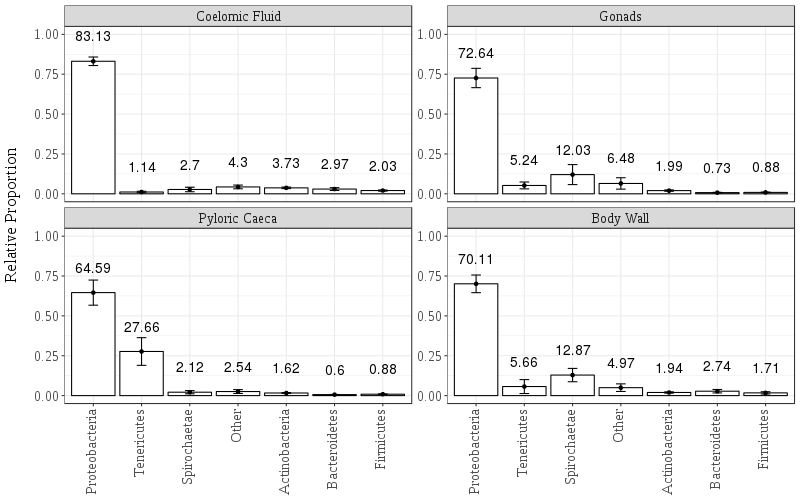

In [69]:
%%R -w 800 -h 500

Tissuenames = c(
                    `PC` = "Pyloric Caeca",
                    `G` = "Gonads",
                    `CF` = "Coelomic Fluid",
                    `TF` = "Body Wall"
                    )

p2 = ggplot(mdf.summary, aes(x= reorder(Rank2.other,-avg), y = avg)) 

p2 = p2 + geom_bar(stat="identity",fill="white", colour="black")

p2 = p2 + facet_wrap(~Sample.Type,scales = "free_y",labeller = as_labeller(Tissuenames)) + xlab("Sample Type") + ylab("Relative Proportion")

p2 = p2 + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.25, size = 15),
                           text=element_text(size=17, color="black", family="Times New Roman"),
                           legend.position="none",
                           axis.title.x=element_blank(),
                           axis.title.y=element_text(margin=margin(0,15,0,0)))

p2 = p2 + geom_point(aes(y = avg), data = mdf.summary) +
    geom_errorbar(aes(y = avg, ymin = avg-(sem), ymax = avg+(sem)), 
                color = "black", width = 0.2, data = mdf.summary)

p2 = p2 + scale_y_continuous(limits = c(0, 1))

p2 = p2 + geom_text(aes(x=Rank2.other, label=proportion), vjust = -2, size=5) 

p2 = p2 + ylab("Relative Proportion") 

p2

## All Tissues Grouped

In [81]:
%%R

mdf.summary = mdf.other %>%
    group_by(Rank2.other) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd(Abundance)/sqrt(length(Abundance)),
              proportion = round(avg*100,2)) %>%
    arrange(desc(avg))

mdf.summary

# A tibble: 7 × 5
     Rank2.other        avg         sd         sem proportion
           <chr>      <dbl>      <dbl>       <dbl>      <dbl>
1 Proteobacteria 0.72296831 0.26778875 0.030921581      72.30
2    Tenericutes 0.10883835 0.26360130 0.030438056      10.88
3   Spirochaetae 0.06971469 0.15332619 0.017704583       6.97
4          Other 0.04387990 0.08933443 0.010315451       4.39
5 Actinobacteria 0.02310526 0.01797416 0.002075477       2.31
6  Bacteroidetes 0.01768949 0.03209967 0.003706551       1.77
7     Firmicutes 0.01380400 0.01836013 0.002120045       1.38


In [57]:
%%R

d = mdf %>%
    group_by(Sample, Rank2, Sample.Type, Genus.Species) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Rank2 %in% topN) 

d$Rank2 = factor(d$Rank2, levels = topN)

In [60]:
%%R
head(d)

Source: local data frame [6 x 5]
Groups: Sample, Rank2, Sample.Type [6]

  Sample          Rank2 Sample.Type       Genus.Species    Abundance
   <chr>         <fctr>       <chr>               <chr>        <dbl>
1 C10_CF Actinobacteria          CF Hippasteria spinosa 0.0301802431
2 C10_CF  Bacteroidetes          CF Hippasteria spinosa 0.0189325136
3 C10_CF     Firmicutes          CF Hippasteria spinosa 0.0160332542
4 C10_CF Proteobacteria          CF Hippasteria spinosa 0.9190303200
5 C10_CF   Spirochaetae          CF Hippasteria spinosa 0.0002794467
6 C10_CF    Tenericutes          CF Hippasteria spinosa 0.0005938242


## Making Plots

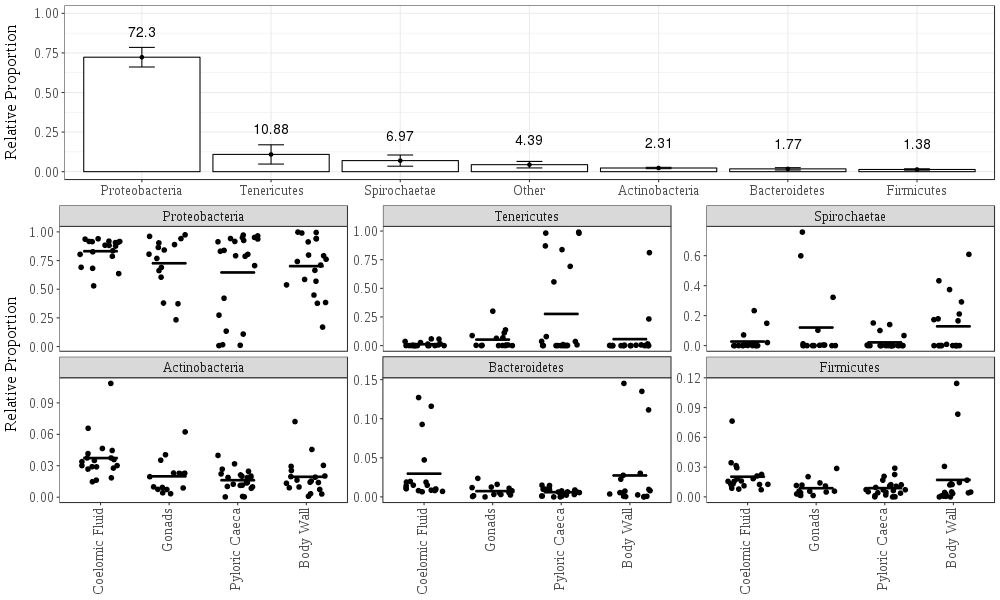

In [64]:
%%R -w 1000 -h 600

## plot 1

p = ggplot(d, aes(x = Sample.Type, y = Abundance, group = Rank2))

p = p + geom_point(size = 2, position = position_jitter(h = 0, w = 0.3))

p = p + facet_wrap(~Rank2, ncol = 3, scales = "free_y") + xlab("Sample Type") + ylab("Relative Proportion")

p = p + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.25, size = 15),
                           text=element_text(size=17, color="black", family="Times New Roman"),
                           legend.key = element_blank(),
                           legend.position = "none",
                           axis.title.x=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           axis.title.y=element_text(margin=margin(0,10,0,0)))

p = p + stat_summary(fun.y = mean, fun.ymin = mean, fun.ymax = mean, geom = "crossbar", width = 0.5)
                                 
p = p + scale_x_discrete(breaks=c("PC", "G", "TF","CF"),
                      labels=c("Pyloric Caeca", "Gonads", "Body Wall","Coelomic Fluid"))

p

## plot 2

p2 = ggplot(mdf.summary, aes(x= reorder(Rank2.other,-avg), y = avg)) 

p2 = p2 + geom_bar(stat="identity",fill="white", colour="black")

p2 = p2 + theme_bw() + theme(text=element_text(size=17, color="black",family ="Times New Roman"),
                           legend.position="none",
                           axis.title.x=element_blank(),
                           axis.title.y=element_text(margin=margin(0,15,0,0)))

p2 = p2 + geom_point(aes(y = avg), data = mdf.summary) +
    geom_errorbar(aes(y = avg, ymin = avg-(2*sem), ymax = avg+(*sem)), 
                color = "black", width = 0.2, data = mdf.summary)

p2 = p2 + scale_y_continuous(limits = c(0, 1))

p2 = p2 + geom_text(aes(x=Rank2.other, label=proportion), vjust = -2, size=5) 

p2 = p2 + ylab("Relative Proportion") 

p2

gridExtra::grid.arrange(p2,p, nrow = 2, heights=c(2, 4))